In [1]:
from theano.sandbox import cuda

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using Theano backend.


14974976/15296311 [============================>.] - ETA: 0s

In [3]:
print y_train[:7]

[5 0 4 1 9 2 1]


# Display the Digits

In [6]:
from matplotlib import pyplot as plt
import utils; reload(utils)
from utils import *

In [7]:
import numpy as np
def gen_image(arr):
    two_d = (np.reshape(arr, (28, 28))).astype(np.uint8)
    plt.imshow(two_d, interpolation=None)
    return plt

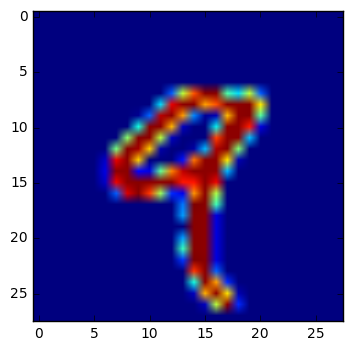

In [8]:
gen_image(x_train[4]).show()

# Prep the data

In [9]:
x_test = np.expand_dims(x_test,1)
x_train = np.expand_dims(x_train,1)

In [10]:
x_train.shape

(60000, 1, 28, 28)

In [11]:
y_train[:5]

array([5, 0, 4, 1, 9], dtype=uint8)

In [12]:
y_train = onehot(y_train)
y_test = onehot(y_test)

In [13]:
y_train[:5]

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])

In [14]:
#Normalization of data
mean_px = x_train.mean().astype(np.float32)
std_px = x_train.std().astype(np.float32)

In [15]:
def norm_input(x): return (x-mean_px)/std_px

# Linear Model

In [16]:
def get_lin_model():
    model = Sequential([
        Lambda(norm_input, input_shape=(1,28,28), output_shape=(1,28,28)),  # Normalize data
        Flatten(), # flatten data to a vector
        Dense(10, activation='softmax')  # multi-classification in logistic regression model
        ])
    
    sgd = keras.optimizers.SGD(lr=0.01)
    model.compile(sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    #model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [17]:
lm = get_lin_model()

In [18]:
gen = image.ImageDataGenerator()
batches = gen.flow(x_train, y_train, batch_size=64)
test_batches = gen.flow(x_test, y_test, batch_size=64)

In [23]:
lm.fit_generator(batches, batches.N, nb_epoch=1, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/1
60000/60000 [==============================] - 11s - loss: 0.5070 - acc: 0.8507 - val_loss: 0.3476 - val_acc: 0.8999


# Single Dense Layer (Using SGD)

In [24]:
def get_fc_model():
    model = Sequential([
        Lambda(norm_input, input_shape=(1,28,28), output_shape=(1,28,28)),  # Normalize data
        Flatten(),
        Dense(512, activation='softmax'),
        Dense(10, activation='softmax')
        ])
    sgd = keras.optimizers.SGD(lr=0.01)
    model.compile(sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [25]:
fc = get_fc_model()

In [26]:
fc.fit_generator(batches, batches.N, nb_epoch=1, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/1
60000/60000 [==============================] - 11s - loss: 2.3000 - acc: 0.1120 - val_loss: 2.2955 - val_acc: 0.1142


In [27]:
fc.optimizer.lr = 0.001

In [28]:
fc.fit_generator(batches, batches.N, nb_epoch=2, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/2
60000/60000 [==============================] - 11s - loss: 2.2671 - acc: 0.1841 - val_loss: 2.2292 - val_acc: 0.2052
Epoch 2/2
60000/60000 [==============================] - 11s - loss: 2.1791 - acc: 0.2435 - val_loss: 2.1017 - val_acc: 0.3451


# Single Dense Layer (Using Adam)

In [29]:
def get_fcadam_model():
    model = Sequential([
        Lambda(norm_input, input_shape=(1,28,28), output_shape=(1,28,28)),  # Normalize data
        Flatten(),
        Dense(512, activation='softmax'),
        Dense(10, activation='softmax')
        ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [30]:
fcadam = get_fcadam_model()

In [31]:
fcadam.fit_generator(batches, batches.N, nb_epoch=2, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/2
60000/60000 [==============================] - 12s - loss: 1.5497 - acc: 0.8877 - val_loss: 1.0146 - val_acc: 0.9252
Epoch 2/2
60000/60000 [==============================] - 12s - loss: 0.7454 - acc: 0.9262 - val_loss: 0.5425 - val_acc: 0.9333


In [32]:
fcadam.optimizer.lr = 0.01

In [34]:
fcadam.fit_generator(batches, batches.N, nb_epoch=2, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/2
60000/60000 [==============================] - 12s - loss: 0.4552 - acc: 0.9331 - val_loss: 0.3818 - val_acc: 0.9357
Epoch 2/2
60000/60000 [==============================] - 12s - loss: 0.3435 - acc: 0.9384 - val_loss: 0.3288 - val_acc: 0.9342


# Basic 'VGG-style' CNN

In [40]:
def get_cnn_model():
    model = Sequential([
        Lambda(norm_input, input_shape=(1,28,28), output_shape=(1,28,28)),
        Conv2D(32, 3,3, activation='relu'),
        Conv2D(32, 3,3, activation='relu'),
        MaxPooling2D(),
        Conv2D(64, 3,3, activation='relu'),
        Conv2D(64, 3,3, activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(10, activation='softmax')
        ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [41]:
cnnmodel = get_cnn_model()

In [42]:
cnnmodel.fit_generator(batches, batches.N, nb_epoch=2, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/2
60000/60000 [==============================] - 20s - loss: 0.1092 - acc: 0.9670 - val_loss: 0.0556 - val_acc: 0.9820
Epoch 2/2
60000/60000 [==============================] - 18s - loss: 0.0356 - acc: 0.9886 - val_loss: 0.0278 - val_acc: 0.9922


In [44]:
cnnmodel.optimizer.lr=0.1

In [45]:
cnnmodel.fit_generator(batches, batches.N, nb_epoch=1, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/1
60000/60000 [==============================] - 20s - loss: 0.0248 - acc: 0.9924 - val_loss: 0.0259 - val_acc: 0.9912


In [46]:
cnnmodel.optimizer.lr=0.01

In [47]:
cnnmodel.fit_generator(batches, batches.N, nb_epoch=8, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/8
60000/60000 [==============================] - 20s - loss: 0.0187 - acc: 0.9939 - val_loss: 0.0263 - val_acc: 0.9923
Epoch 2/8
60000/60000 [==============================] - 19s - loss: 0.0157 - acc: 0.9948 - val_loss: 0.0270 - val_acc: 0.9916
Epoch 3/8
60000/60000 [==============================] - 19s - loss: 0.0117 - acc: 0.9961 - val_loss: 0.0320 - val_acc: 0.9912
Epoch 4/8
60000/60000 [==============================] - 19s - loss: 0.0105 - acc: 0.9968 - val_loss: 0.0315 - val_acc: 0.9909
Epoch 5/8
60000/60000 [==============================] - 20s - loss: 0.0098 - acc: 0.9970 - val_loss: 0.0289 - val_acc: 0.9922
Epoch 6/8
60000/60000 [==============================] - 20s - loss: 0.0087 - acc: 0.9973 - val_loss: 0.0309 - val_acc: 0.9936
Epoch 7/8
60000/60000 [==============================] - 19s - loss: 0.0086 - acc: 0.9972 - val_loss: 0.0285 - val_acc: 0.9929
Epoch 8/8
60000/60000 [==============================] - 19s - loss: 0.0067 - acc: 0.9979 - val_loss: 0.0444 - 

# Data Augmentation

In [49]:
cnnmodel = get_cnn_model()

In [51]:
gen = image.ImageDataGenerator(rotation_range=25)
batches = gen.flow(x_train, y_train, batch_size=64)
test_batches = gen.flow(x_test, y_test, batch_size=64)
cnnmodel.fit_generator(batches, batches.N, nb_epoch=1, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/1
60000/60000 [==============================] - 20s - loss: 0.1503 - acc: 0.9527 - val_loss: 0.0614 - val_acc: 0.9808


In [52]:
gen = image.ImageDataGenerator(rotation_range=50)
batches = gen.flow(x_train, y_train, batch_size=64)
test_batches = gen.flow(x_test, y_test, batch_size=64)
cnnmodel.fit_generator(batches, batches.N, nb_epoch=1, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/1
60000/60000 [==============================] - 20s - loss: 0.0863 - acc: 0.9727 - val_loss: 0.0556 - val_acc: 0.9824


In [53]:
gen = image.ImageDataGenerator(rotation_range=10)
batches = gen.flow(x_train, y_train, batch_size=64)
test_batches = gen.flow(x_test, y_test, batch_size=64)
cnnmodel.fit_generator(batches, batches.N, nb_epoch=1, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/1
60000/60000 [==============================] - 20s - loss: 0.0363 - acc: 0.9887 - val_loss: 0.0310 - val_acc: 0.9897


In [54]:
gen = image.ImageDataGenerator(rotation_range=90)
batches = gen.flow(x_train, y_train, batch_size=64)
test_batches = gen.flow(x_test, y_test, batch_size=64)
cnnmodel.fit_generator(batches, batches.N, nb_epoch=1, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/1
60000/60000 [==============================] - 20s - loss: 0.1132 - acc: 0.9650 - val_loss: 0.0771 - val_acc: 0.9738


In [55]:
# Use this one
gen = image.ImageDataGenerator(rotation_range=7)
batches = gen.flow(x_train, y_train, batch_size=64)
test_batches = gen.flow(x_test, y_test, batch_size=64)
cnnmodel.fit_generator(batches, batches.N, nb_epoch=1, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/1
60000/60000 [==============================] - 20s - loss: 0.0293 - acc: 0.9911 - val_loss: 0.0261 - val_acc: 0.9919


In [56]:
gen = image.ImageDataGenerator(rotation_range=5)
batches = gen.flow(x_train, y_train, batch_size=64)
test_batches = gen.flow(x_test, y_test, batch_size=64)
cnnmodel.fit_generator(batches, batches.N, nb_epoch=1, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/1
60000/60000 [==============================] - 20s - loss: 0.0172 - acc: 0.9948 - val_loss: 0.0265 - val_acc: 0.9919


In [85]:
gen = image.ImageDataGenerator(width_shift_range=0.3)
batches = gen.flow(x_train, y_train, batch_size=64)
test_batches = gen.flow(x_test, y_test, batch_size=64)
cnnmodel.fit_generator(batches, batches.N, nb_epoch=1, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/1
60000/60000 [==============================] - 20s - loss: 0.0561 - acc: 0.9839 - val_loss: 0.0352 - val_acc: 0.9881


In [87]:
gen = image.ImageDataGenerator(width_shift_range=0.25)
batches = gen.flow(x_train, y_train, batch_size=64)
test_batches = gen.flow(x_test, y_test, batch_size=64)
cnnmodel.fit_generator(batches, batches.N, nb_epoch=1, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/1
60000/60000 [==============================] - 20s - loss: 0.0197 - acc: 0.9942 - val_loss: 0.0263 - val_acc: 0.9925


In [58]:
gen = image.ImageDataGenerator(width_shift_range=0.2)
batches = gen.flow(x_train, y_train, batch_size=64)
test_batches = gen.flow(x_test, y_test, batch_size=64)
cnnmodel.fit_generator(batches, batches.N, nb_epoch=1, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/1
60000/60000 [==============================] - 20s - loss: 0.0469 - acc: 0.9852 - val_loss: 0.0316 - val_acc: 0.9906


In [86]:
# Use this one
gen = image.ImageDataGenerator(width_shift_range=0.15)
batches = gen.flow(x_train, y_train, batch_size=64)
test_batches = gen.flow(x_test, y_test, batch_size=64)
cnnmodel.fit_generator(batches, batches.N, nb_epoch=1, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/1
60000/60000 [==============================] - 20s - loss: 0.0102 - acc: 0.9970 - val_loss: 0.0231 - val_acc: 0.9937


In [59]:
gen = image.ImageDataGenerator(width_shift_range=0.1)
batches = gen.flow(x_train, y_train, batch_size=64)
test_batches = gen.flow(x_test, y_test, batch_size=64)
cnnmodel.fit_generator(batches, batches.N, nb_epoch=1, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/1
60000/60000 [==============================] - 20s - loss: 0.0178 - acc: 0.9947 - val_loss: 0.0373 - val_acc: 0.9882


In [60]:
gen = image.ImageDataGenerator(width_shift_range=0.05)
batches = gen.flow(x_train, y_train, batch_size=64)
test_batches = gen.flow(x_test, y_test, batch_size=64)
cnnmodel.fit_generator(batches, batches.N, nb_epoch=1, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/1
60000/60000 [==============================] - 20s - loss: 0.0121 - acc: 0.9962 - val_loss: 0.0274 - val_acc: 0.9923


In [88]:
gen = image.ImageDataGenerator(rotation_range=7, width_shift_range=0.15)
batches = gen.flow(x_train, y_train, batch_size=64)
test_batches = gen.flow(x_test, y_test, batch_size=64)
cnnmodel.fit_generator(batches, batches.N, nb_epoch=1, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/1
60000/60000 [==============================] - 20s - loss: 0.0132 - acc: 0.9960 - val_loss: 0.0295 - val_acc: 0.9927


In [62]:
gen = image.ImageDataGenerator(shear_range=0.2)
batches = gen.flow(x_train, y_train, batch_size=64)
test_batches = gen.flow(x_test, y_test, batch_size=64)
cnnmodel.fit_generator(batches, batches.N, nb_epoch=1, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/1
60000/60000 [==============================] - 19s - loss: 0.0130 - acc: 0.9960 - val_loss: 0.0229 - val_acc: 0.9923


In [63]:
gen = image.ImageDataGenerator(shear_range=0.1)
batches = gen.flow(x_train, y_train, batch_size=64)
test_batches = gen.flow(x_test, y_test, batch_size=64)
cnnmodel.fit_generator(batches, batches.N, nb_epoch=1, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/1
60000/60000 [==============================] - 20s - loss: 0.0079 - acc: 0.9973 - val_loss: 0.0233 - val_acc: 0.9942


In [89]:
# Use this one
gen = image.ImageDataGenerator(shear_range=0.07)
batches = gen.flow(x_train, y_train, batch_size=64)
test_batches = gen.flow(x_test, y_test, batch_size=64)
cnnmodel.fit_generator(batches, batches.N, nb_epoch=1, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/1
60000/60000 [==============================] - 20s - loss: 0.0017 - acc: 0.9995 - val_loss: 0.0188 - val_acc: 0.9952


In [67]:
gen = image.ImageDataGenerator(shear_range=0.3)
batches = gen.flow(x_train, y_train, batch_size=64)
test_batches = gen.flow(x_test, y_test, batch_size=64)
cnnmodel.fit_generator(batches, batches.N, nb_epoch=1, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/1
60000/60000 [==============================] - 20s - loss: 0.0143 - acc: 0.9953 - val_loss: 0.0253 - val_acc: 0.9930


In [90]:
gen = image.ImageDataGenerator(rotation_range=7, width_shift_range=0.15, shear_range=0.07)
batches = gen.flow(x_train, y_train, batch_size=64)
test_batches = gen.flow(x_test, y_test, batch_size=64)
cnnmodel.fit_generator(batches, batches.N, nb_epoch=1, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/1
60000/60000 [==============================] - 20s - loss: 0.0178 - acc: 0.9946 - val_loss: 0.0321 - val_acc: 0.9918


In [83]:
gen = image.ImageDataGenerator(height_shift_range=0.3)
batches = gen.flow(x_train, y_train, batch_size=64)
test_batches = gen.flow(x_test, y_test, batch_size=64)
cnnmodel.fit_generator(batches, batches.N, nb_epoch=1, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/1
60000/60000 [==============================] - 20s - loss: 0.0731 - acc: 0.9772 - val_loss: 0.0563 - val_acc: 0.9828


In [71]:
gen = image.ImageDataGenerator(height_shift_range=0.2)
batches = gen.flow(x_train, y_train, batch_size=64)
test_batches = gen.flow(x_test, y_test, batch_size=64)
cnnmodel.fit_generator(batches, batches.N, nb_epoch=1, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/1
60000/60000 [==============================] - 20s - loss: 0.0551 - acc: 0.9839 - val_loss: 0.0368 - val_acc: 0.9875


In [72]:
gen = image.ImageDataGenerator(height_shift_range=0.1)
batches = gen.flow(x_train, y_train, batch_size=64)
test_batches = gen.flow(x_test, y_test, batch_size=64)
cnnmodel.fit_generator(batches, batches.N, nb_epoch=1, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/1
60000/60000 [==============================] - 20s - loss: 0.0133 - acc: 0.9961 - val_loss: 0.0249 - val_acc: 0.9932


In [82]:
gen = image.ImageDataGenerator(height_shift_range=0.08)
batches = gen.flow(x_train, y_train, batch_size=64)
test_batches = gen.flow(x_test, y_test, batch_size=64)
cnnmodel.fit_generator(batches, batches.N, nb_epoch=1, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/1
60000/60000 [==============================] - 20s - loss: 0.0127 - acc: 0.9963 - val_loss: 0.0211 - val_acc: 0.9939


In [84]:
gen = image.ImageDataGenerator(height_shift_range=0.05)
batches = gen.flow(x_train, y_train, batch_size=64)
test_batches = gen.flow(x_test, y_test, batch_size=64)
cnnmodel.fit_generator(batches, batches.N, nb_epoch=1, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/1
60000/60000 [==============================] - 20s - loss: 0.0051 - acc: 0.9984 - val_loss: 0.0247 - val_acc: 0.9940


In [92]:
gen = image.ImageDataGenerator(rotation_range=7, width_shift_range=0.15, shear_range=0.07,  height_shift_range=0.08)
batches = gen.flow(x_train, y_train, batch_size=64)
test_batches = gen.flow(x_test, y_test, batch_size=64)
cnnmodel.fit_generator(batches, batches.N, nb_epoch=1, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/1
60000/60000 [==============================] - 20s - loss: 0.0216 - acc: 0.9934 - val_loss: 0.0308 - val_acc: 0.9911


In [76]:
gen = image.ImageDataGenerator(zoom_range=0.2)
batches = gen.flow(x_train, y_train, batch_size=64)
test_batches = gen.flow(x_test, y_test, batch_size=64)
cnnmodel.fit_generator(batches, batches.N, nb_epoch=1, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/1
60000/60000 [==============================] - 21s - loss: 0.0140 - acc: 0.9955 - val_loss: 0.0223 - val_acc: 0.9921


In [77]:
gen = image.ImageDataGenerator(zoom_range=0.1)
batches = gen.flow(x_train, y_train, batch_size=64)
test_batches = gen.flow(x_test, y_test, batch_size=64)
cnnmodel.fit_generator(batches, batches.N, nb_epoch=1, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/1
60000/60000 [==============================] - 21s - loss: 0.0046 - acc: 0.9984 - val_loss: 0.0328 - val_acc: 0.9929


In [81]:
gen = image.ImageDataGenerator(zoom_range=0.08)
batches = gen.flow(x_train, y_train, batch_size=64)
test_batches = gen.flow(x_test, y_test, batch_size=64)
cnnmodel.fit_generator(batches, batches.N, nb_epoch=1, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/1
60000/60000 [==============================] - 19s - loss: 0.0046 - acc: 0.9985 - val_loss: 0.0338 - val_acc: 0.9938


In [78]:
gen = image.ImageDataGenerator(zoom_range=0.05)
batches = gen.flow(x_train, y_train, batch_size=64)
test_batches = gen.flow(x_test, y_test, batch_size=64)
cnnmodel.fit_generator(batches, batches.N, nb_epoch=1, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/1
60000/60000 [==============================] - 20s - loss: 0.0033 - acc: 0.9990 - val_loss: 0.0198 - val_acc: 0.9957


In [79]:
gen = image.ImageDataGenerator(zoom_range=0.03)
batches = gen.flow(x_train, y_train, batch_size=64)
test_batches = gen.flow(x_test, y_test, batch_size=64)
cnnmodel.fit_generator(batches, batches.N, nb_epoch=1, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/1
60000/60000 [==============================] - 20s - loss: 0.0032 - acc: 0.9990 - val_loss: 0.0347 - val_acc: 0.9926


In [93]:
gen = image.ImageDataGenerator(rotation_range=7, width_shift_range=0.15, shear_range=0.07, 
                               height_shift_range=0.08, zoom_range=0.3)
batches = gen.flow(x_train, y_train, batch_size=64)
test_batches = gen.flow(x_test, y_test, batch_size=64)
cnnmodel.fit_generator(batches, batches.N, nb_epoch=1, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/1
60000/60000 [==============================] - 20s - loss: 0.0486 - acc: 0.9858 - val_loss: 0.0462 - val_acc: 0.9839


In [95]:
cnnmodel.optimizer.lr=0.1

In [96]:
cnnmodel.fit_generator(batches, batches.N, nb_epoch=4, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/4
60000/60000 [==============================] - 20s - loss: 0.0373 - acc: 0.9880 - val_loss: 0.0449 - val_acc: 0.9872
Epoch 2/4
60000/60000 [==============================] - 20s - loss: 0.0388 - acc: 0.9880 - val_loss: 0.0486 - val_acc: 0.9834
Epoch 3/4
60000/60000 [==============================] - 20s - loss: 0.0335 - acc: 0.9899 - val_loss: 0.0353 - val_acc: 0.9897
Epoch 4/4
60000/60000 [==============================] - 20s - loss: 0.0349 - acc: 0.9891 - val_loss: 0.0368 - val_acc: 0.9888


In [98]:
cnnmodel.optimizer.lr=0.01

In [99]:
cnnmodel.fit_generator(batches, batches.N, nb_epoch=4, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/4
60000/60000 [==============================] - 20s - loss: 0.0342 - acc: 0.9896 - val_loss: 0.0355 - val_acc: 0.9887
Epoch 2/4
60000/60000 [==============================] - 19s - loss: 0.0312 - acc: 0.9904 - val_loss: 0.0430 - val_acc: 0.9871
Epoch 3/4
60000/60000 [==============================] - 19s - loss: 0.0302 - acc: 0.9908 - val_loss: 0.0341 - val_acc: 0.9895
Epoch 4/4
60000/60000 [==============================] - 20s - loss: 0.0297 - acc: 0.9909 - val_loss: 0.0355 - val_acc: 0.9894


In [100]:
cnnmodel.optimizer.lr=0.001

In [101]:
cnnmodel.fit_generator(batches, batches.N, nb_epoch=6, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/6
60000/60000 [==============================] - 20s - loss: 0.0305 - acc: 0.9908 - val_loss: 0.0348 - val_acc: 0.9884
Epoch 2/6
60000/60000 [==============================] - 20s - loss: 0.0311 - acc: 0.9906 - val_loss: 0.0372 - val_acc: 0.9902
Epoch 3/6
60000/60000 [==============================] - 20s - loss: 0.0290 - acc: 0.9911 - val_loss: 0.0374 - val_acc: 0.9874
Epoch 4/6
60000/60000 [==============================] - 20s - loss: 0.0276 - acc: 0.9915 - val_loss: 0.0352 - val_acc: 0.9896
Epoch 5/6
60000/60000 [==============================] - 19s - loss: 0.0303 - acc: 0.9909 - val_loss: 0.0367 - val_acc: 0.9885
Epoch 6/6
60000/60000 [==============================] - 20s - loss: 0.0280 - acc: 0.9910 - val_loss: 0.0329 - val_acc: 0.9897


In [102]:
cnnmodel.optimizer.lr=0.0001

In [ ]:
model.fit_generator(batches, batches.N, nb_epoch=10, 
                    validation_data=test_batches, nb_val_samples=test_batches.N)